In [82]:
import numpy as np
import tensorflow as tf

nx = 2000 # Banyaknya data dalam domain

# Mendefinisikan domain
x = np.linspace(0, np.pi, nx) # Berarti dari (0, pi) terdapat 2000 data yang akan digunakan sebagai input
x = np.reshape(x, (-1,1)) # Mengubah ukuran input menjadi 2000x1

# Solusi analitik
exact_ut = 0.5*np.exp(-x)*np.sin(2*x)

# Mendefinisikan data untuk training
n = 1500
idx = np.random.choice(x.shape[0], n, replace=False) # Dari total 2000 data, hanya 1500 yang digunakan untuk proses training
x_train = x[idx, :]

u_train = exact_ut[idx, :] # Nilai analitik pada setiap index yang sama dengan input

In [83]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

model_nn = Sequential([Dense(50, activation="tanh", kernel_initializer='normal', input_shape=x_train.shape[1:]),
                       Dense(50, kernel_initializer='normal', activation='tanh'),
                       Dense(50, kernel_initializer='normal', activation='tanh'),
                       Dense(1, kernel_initializer='normal')])

opt = keras.optimizers.Adam(learning_rate = 0.001)

In [84]:
def __loss(x_train, g_train):
    x0 = np.array(0).reshape(-1, 1)
    x0 = tf.convert_to_tensor(x0, dtype=tf.float32)
    g0 = tf.constant(0, dtype = tf.float32)

    g0_pred = model_nn(x0)
    _, g_x_pred = g_x_model()
    g_pred = g_model()

    loss_g0 = tf.reduce_mean(tf.square(g0 - g0_pred))
    loss_g1 = tf.reduce_mean(tf.square(g_x_pred))
    loss_g = tf.reduce_mean(tf.square(g_pred))

    return loss_g0 + loss_g1 + loss_g

# The actual PINN
def g_model():
    x_f = tf.convert_to_tensor(x_train, dtype=tf.float32)
    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_f)
        with tf.GradientTape(persistent=True) as gtape:
            gtape.watch(x_f)
            # Getting the prediction
            g = model_nn(x_f)
        g_x = gtape.gradient(g, x_f)
        del gtape
    g_xx = tape.gradient(g_x, x_f)
    # Letting the tape go
    del tape
    a = tf.constant(2.0, dtype=tf.float32)
    b = tf.constant(5.0, dtype=tf.float32)
    # Buidling the PINNs
    return  g_xx + a*g_x + b*g

def g_x_model():
    x0 = np.array(0).reshape(-1, 1)
    x0 = tf.convert_to_tensor(x0, dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x0)
        g = model_nn(x0)
    g_x = tape.gradient(g, x0)
    del tape
    return g, g_x - 1

In [85]:
import matplotlib.pyplot as plt

class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test, model_name):
        self.x_test = x_test
        self.y_test = y_test
        self.model_name = model_name
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x_test)
        fig, ax = plt.subplots(figsize=(8,4))
        exact = exact_ut
        plt.plot(x, exact, lw =3, ls = '-', label = 'Analytical solution')
        plt.plot(self.x_test, y_pred, lw =2, ls = '--', label = 'ANN Prediction')

        plt.ticklabel_format(useOffset=False, style='plain')
        plt.xlabel('x', fontsize=15)
        plt.ylabel('g(x)', fontsize=15)
        plt.ylim([-0.1, 0.3])

        plt.tight_layout()
        plt.title(f'Analytical solution vs ANN prediction - Iteration: {epoch}')
        plt.legend()
        plt.savefig('model_train_images/'+self.model_name+"_"+str(epoch))
        plt.close()

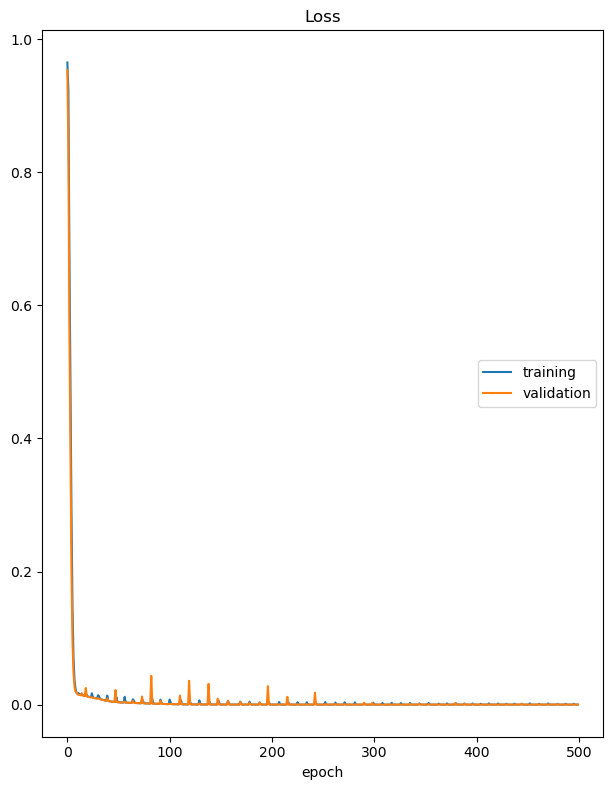

Loss
	training         	 (min:    0.000, max:    0.965, cur:    0.000)
	validation       	 (min:    0.000, max:    0.954, cur:    0.000)
40/40 [==============================] - 1s 21ms/step - loss: 1.0812e-05 - val_loss: 1.0695e-05
Elapsed 421.891 seconds.


In [86]:
import time
from livelossplot import PlotLossesKeras

plotlosses = PlotLossesKeras()
performance = PerformancePlotCallback(x, exact_ut, "performance_model")
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model3.h5", save_best_only=True)

start = time.perf_counter()

model_nn.compile(loss=__loss, optimizer=opt)
history = model_nn.fit(x_train, u_train, epochs = 500,
                callbacks=[checpoint_cb, plotlosses, performance], verbose=1, validation_split=0.15)
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

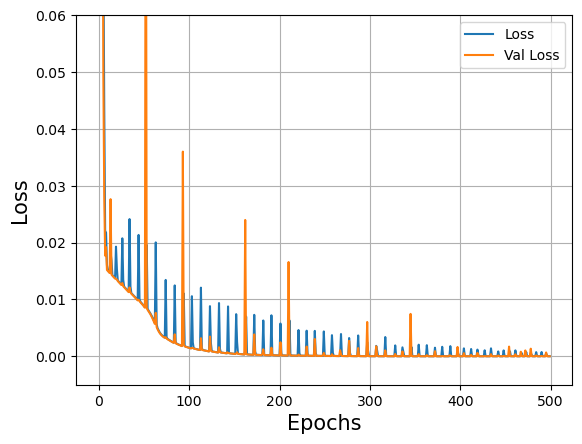

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.grid(True)
plt.gca().set_ylim(-0.005, 0.06) # set the vertical range
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.show()

In [65]:
y1.shape

(500,)

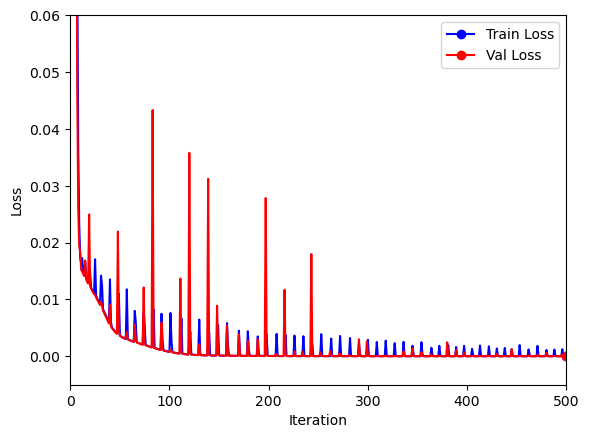

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation

from IPython.display import HTML


def animate(i, data1, data2, line1, line2):
    
    temp1 = data1.iloc[:int(i+1)]
    temp2 = data2.iloc[:int(i+1)]
    line1.set_data(temp1.index, temp1.value)
    line2.set_data(temp2.index, temp2.value)
    return (line1, line2)


def create_loss_animation(model_type, data1, data2):
    fig = plt.figure()

    # set up the subplots as needed
    plt.xlim(( 0, 500))            
    plt.ylim((-0.005, 0.06))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    l1, = plt.plot([], [], 'o-', label='Train Loss', color='b', markevery=[-1])
    l2, = plt.plot([], [], 'o-', label='Val Loss', color='r', markevery=[-1])
    plt.legend(loc='upper right')
    
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=5, bitrate=1800)

    ani = matplotlib.animation.FuncAnimation(fig, animate, fargs=(data1, data2, l1, l2), repeat=True, frames=500, interval=50, repeat_delay=1000, blit=True)
    ani.save(f'{model_type}.gif', writer=writer)
    return ani

# create datasets
x = np.linspace(1,500,500)
y1 = history.history['loss']
y1 = np.array(y1).reshape(-1, )
y2 = history.history['val_loss']
y2 = np.array(y2).reshape(-1, )

my_data_number_1 = pd.DataFrame({'x':x, 'value':y1}).set_index('x')
my_data_number_2 = pd.DataFrame({'x':x, 'value':y2}).set_index('x')

HTML(create_loss_animation('test', my_data_number_1, my_data_number_2).to_html5_video())

In [ ]:
# Generating Predictions on testing data
Predictions=model_nn.predict(x)
mse_ann_test = model_nn.evaluate(x, exact_gt)
print('ANN MSE:', mse_ann_test)

In [97]:
import matplotlib.pyplot as plt
import imageio

In [98]:
from pathlib import Path

frames = []
for file in Path("model_train_images").iterdir():
    frames.append(imageio.v3.imread(file))

In [99]:
imageio.mimsave('example.gif', # output gif
                frames,          # array of input frames
                fps = 5)         # optional: frames per second